<a href="https://colab.research.google.com/github/camilodlt/rtidy-python/blob/main/Computer%20vision/CIFAR/Basic_API_of_AutoKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!nvidia-smi

Mon Sep  6 09:14:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%%capture
!pip install tensorflow==2.3.0
!pip install autokeras

In [2]:
import tensorflow as tf 
tf.config.list_physical_devices('GPU') 


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# LOAD LIBS ------
import autokeras as ak
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler


In [4]:
ak.__version__

'1.0.16'

In [5]:
tf.__version__

'2.3.0'

## Load CIFAR10 dataset and visualize the CIFAR10 images

In [6]:
# we can simplely use the tf.keras.datasets.cifar10.load_data API to load dataset
(x_train, y_train), (x_test, y_test) =  tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


### Preprocess the image data, including normalizing and reshape

In [7]:
# CURRENT SHAPES ------
print("x_train shape: ",x_train.shape) # channels last
print("x_test shape: ",x_test.shape) # channels last

print("y_train shape: ",y_train.shape)  
print("y_test shape: ",y_test.shape)

# NORMALIZE ------
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train.reshape((-1,32*32*3)))
x_test= scaler.transform(x_test.reshape((-1,32*32*3)))

# Reshaping ---
x_train=x_train.reshape((-1,32,32,3))
x_test=x_test.reshape((-1,32,32,3))

means= scaler.mean_
stds= scaler.var_

x_train shape:  (50000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)
y_train shape:  (50000, 1)
y_test shape:  (10000, 1)


Let's plot some image to be sure of the reshaping

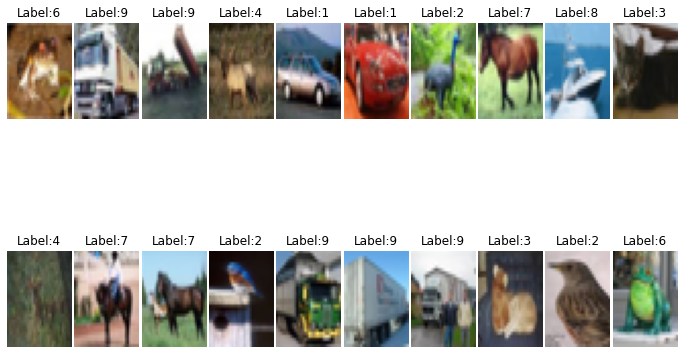

In [ ]:
# PRINT SOME IMAGES ------
_, axs = plt.subplots(2, 10, figsize=(12, 8),gridspec_kw={'wspace':0.05, 'hspace':0.1},squeeze=True)
axs = axs.flatten()
for img,y, ax in zip(x_train[0:21],y_train[0:21], axs):
    img= img.reshape((32*32*3))*np.sqrt(stds)+means
    img= img.reshape((32,32,3))
    img /=255
    ax.axis('off')
    ax.imshow(img,aspect='1.5')
    ax.set_title(f"Label:{str(y[0])}")
plt.show();

## Build an automated image classification model using AutoKeras Task API


Let's remember that our previous best results were : 
- Accuracy : 0.684900
- Loss: 0.962091

In [8]:
from sklearn.utils import resample
x_train_sampled, y_train_sampled = resample(x_train, y_train, n_samples=5000, replace=False, random_state=0)

In [ ]:
# Initialize the image classifier.
clf = ak.ImageClassifier(max_trials=8,loss='sparse_categorical_crossentropy',objective= 'val_accuracy')
# Search for the best model
clf.fit(x_train_sampled, y_train_sampled, epochs=3)

Trial 8 Complete [00h 00m 21s]
val_accuracy: 0.4948347210884094

Best val_accuracy So Far: 0.5
Total elapsed time: 04h 00m 13s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
157/157 [==============================] - 8s 48ms/step - loss: 1.7794 - accuracy: 0.3670
Epoch 2/3
157/157 [==============================] - 8s 48ms/step - loss: 1.3321 - accuracy: 0.5252
Epoch 3/3
157/157 [==============================] - 7s 47ms/step - loss: 1.1050 - accuracy: 0.6164
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


Let's chek the best parameters for the model. 

In [ ]:
# Exporting the model
ak_model= clf.export_model()

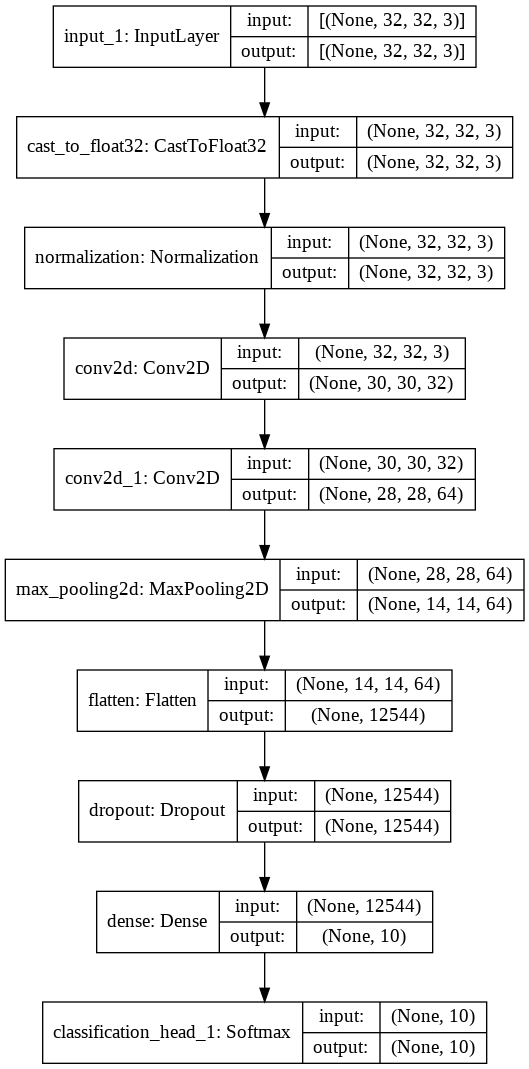

In [ ]:
tf.keras.utils.plot_model(ak_model, to_file="model.png", show_shapes=True)

In [ ]:
# Saving the model 
ak_model.save('/content/drive/MyDrive/Autokeras/auto_keras_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Autokeras/auto_keras_1/assets


Let's retrain with all the data. 


In [ ]:
from tensorflow.keras.models import load_model
model_searched = load_model("/content/drive/MyDrive/Autokeras/auto_keras_1")

# Retrain --- 
# compile the model and train the model
model_searched.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_searched.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.20)

Epoch 1/10
625/625 [==============================] - 55s 88ms/step - loss: 1.1718 - accuracy: 0.5911 - val_loss: 1.0142 - val_accuracy: 0.6478
Epoch 2/10
625/625 [==============================] - 53s 85ms/step - loss: 0.9811 - accuracy: 0.6595 - val_loss: 0.9476 - val_accuracy: 0.6751
Epoch 3/10
625/625 [==============================] - 53s 86ms/step - loss: 0.8804 - accuracy: 0.6951 - val_loss: 0.9460 - val_accuracy: 0.6778
Epoch 4/10
625/625 [==============================] - 54s 86ms/step - loss: 0.8153 - accuracy: 0.7166 - val_loss: 0.9125 - val_accuracy: 0.6887
Epoch 5/10
625/625 [==============================] - 53s 86ms/step - loss: 0.7617 - accuracy: 0.7334 - val_loss: 0.8834 - val_accuracy: 0.6963
Epoch 6/10
625/625 [==============================] - 54s 86ms/step - loss: 0.7237 - accuracy: 0.7475 - val_loss: 0.8710 - val_accuracy: 0.7071
Epoch 7/10
625/625 [==============================] - 54s 87ms/step - loss: 0.6880 - accuracy: 0.7599 - val_loss: 0.8703 - val_accuracy:

In [ ]:
# Save the model again --- 
model_searched.save("/content/drive/MyDrive/Autokeras/auto_keras_2")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Autokeras/auto_keras_2/assets


## Test and explore the searched MLP

In [ ]:
# Evaluate the best model with testing data.
loss, acc= model_searched.evaluate(x_test, y_test)
print("Test Loss: ",loss)
print("Test Accuracy: ",acc)

313/313 [==============================] - 3s 10ms/step - loss: 0.8661 - accuracy: 0.7085
Test Loss:  0.8660763502120972
Test Accuracy:  0.7085000276565552


## Input different data format


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds

<TensorSliceDataset shapes: ((32, 32, 3), (1,)), types: (tf.float64, tf.uint8)>

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds

<TensorSliceDataset shapes: ((32, 32, 3), (1,)), types: (tf.float64, tf.uint8)>

In [ ]:
batches=train_ds.batch(64)

Clearly our model overfitted a bit, we should probably try less epochs furing training. 

In [ ]:
model_searched.evaluate(batches)

782/782 [==============================] - 17s 21ms/step - loss: 0.4828 - accuracy: 0.8482


[0.48283007740974426, 0.8482000231742859]

## Configure the search process

In [10]:
# Initialize the image classifier.
clf = ak.ImageClassifier(max_trials=8,metrics=['accuracy'],objective='val_loss')# We pick the best val_loss model. 
# Search for the best model
clf.fit(x=x_train_sampled, y= y_train_sampled, epochs=10)

Trial 7 Complete [00h 42m 39s]
val_loss: 0.2527894973754883

Best val_loss So Far: 0.236379474401474
Total elapsed time: 03h 55m 34s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/10
Not enough memory, reduce batch size to 16.
Epoch 1/10
313/313 [==============================] - 291s 928ms/step - loss: 1.6826 - accuracy: 0.4826
Epoch 2/10
313/313 [==============================] - 292s 932ms/step - loss: 0.7252 - accuracy: 0.7928
Epoch 3/10
313/313 [==============================] - 292s 932ms/step - lo

In [ ]:
# Exporting the model
ak_model= clf.export_model()
# Saving the model 
ak_model.save('/content/drive/MyDrive/Autokeras/auto_keras_3')

In [14]:
ak_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Evaluate the best model with testing data.
loss, acc= ak_model.evaluate(x_test, y_test)
print("Test Loss: ",loss)
print("Test Accuracy: ",acc)

313/313 [==============================] - 106s 339ms/step - loss: 0.2433 - accuracy: 0.9254
Test Loss:  0.2432708740234375
Test Accuracy:  0.9254000186920166


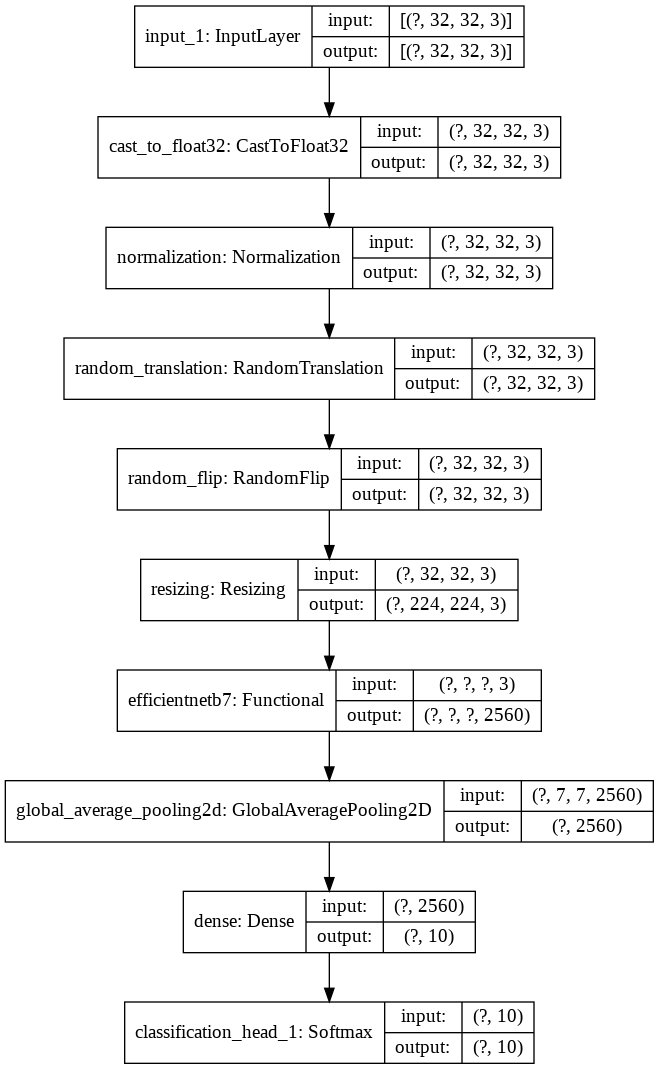

In [15]:
tf.keras.utils.plot_model(ak_model, to_file="model.png", show_shapes=True)

Our model know achieved an accuracy of 92% on the test set. This model was not even fitted on the entire training set! 

Clearly Auto Keras found a sweet spot, it uses the efficient net as backbone, performs some data augmentation.


What's interesting is that it resizes all images (32,32) to (224, 224). Even with this extreme resizing, the model achieves impressive results. 